# Field distortion characterization
In this note, we explain how the field distortion caused by the cylindrical lens is characterized and encoded in the sensing matrx. Four parst are discussed
1. Experimental Characterization
2. Field distortion fitting
3. Field distortion incoporation in the sensing matrix
4. The usage with PyPRIS package.

Note: X coordinates range: 75 to 175

In [2]:
# import tools
from nd2reader import ND2Reader
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit
import copy
%matplotlib inline
data_folder = 'G:/DH_localization/Experiments_Phase2_afterSPIE/NW_astig_spetrum_data/April19_2019_more3DsampleFromKiHee/For UCLA'

## load the dataset

In [3]:
# load data
calib1 = ND2Reader( data_folder + '/Cali_Fielddistortion002.nd2')   
calib2 = ND2Reader( data_folder + '/Cali_Fielddistortion003.nd2')  
calib3_woCL = ND2Reader( data_folder + '/Cali_FielddistortionwoCL.nd2')  

## find 2D peaks

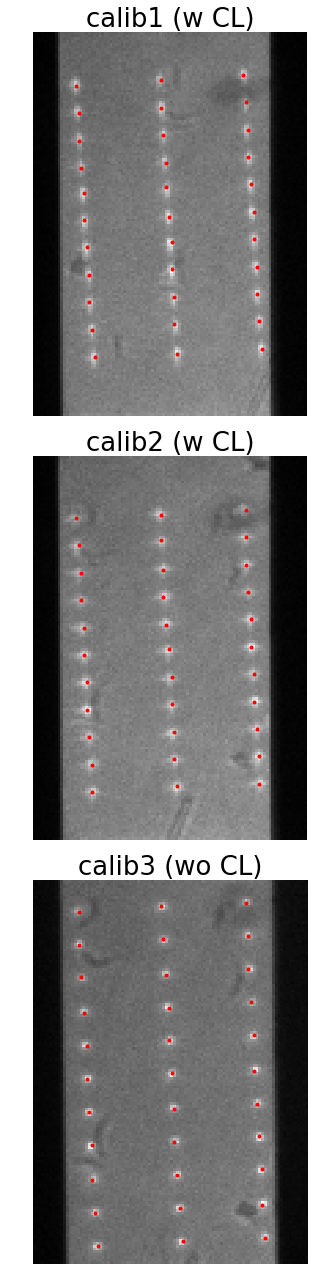

In [7]:
# detect 3D peaks
im_list = list()
peaks_list = list()
title_list = ['calib1 (w CL)','calib2 (w CL)','calib3 (wo CL)']


im_list.append(np.asarray(calib1[2][:,75:175]))
im_list.append(np.asarray(calib2[2][:,75:175]))
im_list.append(np.asarray(calib3_woCL[2][:,75:175]))

# image_max is the dilation of im with a 2*2 structuring element
# It is used within peak_local_max function
for im in im_list:
    image_max = ndi.maximum_filter(im, size=6, mode='constant') # the mode option doesn't seem to play a significant role.

    # Comparison between image_max and im to find the coordinates of local maxima
    coordinates = peak_local_max(im, min_distance=4)
    peaks = np.column_stack((coordinates, im[coordinates[:,0],coordinates[:,1]]))
    peaks = peaks[np.where(peaks[:,2]>27800)] # get only the desired peaks
    peaks = peaks[np.where(peaks[:,1]<180)] # get only the left section
    peaks_list.append(copy.deepcopy(peaks))


# display results
fig, axes = plt.subplots(3, 1, figsize=(18, 18), sharex=True, sharey=True)
i = 0
ax = axes.ravel()
for im, title, peaks in zip(im_list, title_list, peaks_list):
    ax[i].imshow(im, cmap=plt.cm.gray)
    ax[i].autoscale(False)
    ax[i].plot(peaks[:, 1], peaks[:, 0], 'r.')
    ax[i].axis('off')
    ax[i].set_title(title, fontsize=26)
    i += 1
    
fig.tight_layout()
plt.show()

## Check the coordinates

Text(-20,-55,'we can see some distortion in the x coordiantes as well')

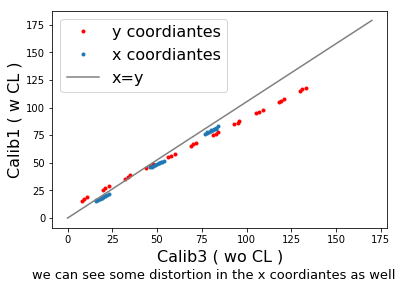

In [8]:
# check coordinates
plt.plot(peaks_list[2][:,0],peaks_list[0][:,0],'r.')
plt.plot(peaks_list[2][:,1],peaks_list[0][:,1],'.')
plt.plot([0,170],[0,179],'gray')
plt.legend(['y coordiantes','x coordiantes', 'x=y'], fontsize=16)
plt.xlabel('Calib3 ( wo CL )', fontsize=16)
plt.ylabel('Calib1 ( w CL )', fontsize=16)
plt.text(-20,-55,'we can see some distortion in the x coordiantes as well', fontsize=13)

Text(-20,-55,'we can see some distortion in the x coordiantes as well')

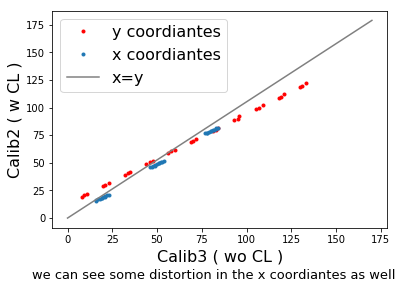

In [9]:
# check coordinates
plt.plot(peaks_list[2][:,0],peaks_list[1][:,0],'r.')
plt.plot(peaks_list[2][:,1],peaks_list[1][:,1],'.')
plt.plot([0,170],[0,179],'gray')
plt.legend(['y coordiantes','x coordiantes', 'x=y'], fontsize=16)
plt.xlabel('Calib3 ( wo CL )', fontsize=16)
plt.ylabel('Calib2 ( w CL )', fontsize=16)
plt.text(-20,-55,'we can see some distortion in the x coordiantes as well', fontsize=13)

Text(-20,-55,'This plot should overlap with the x=y curve, but seems like there is a constant shift')

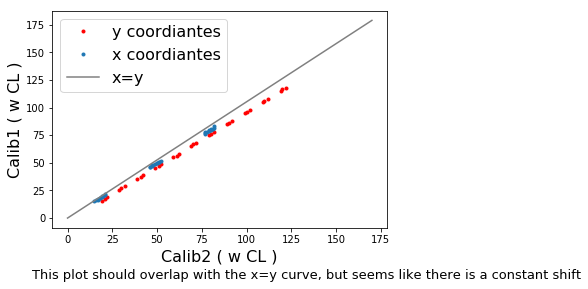

In [10]:
# check coordinates
plt.plot(peaks_list[1][:,0],peaks_list[0][:,0],'r.')
plt.plot(peaks_list[1][:,1],peaks_list[0][:,1],'.')
plt.plot([0,170],[0,179],'gray')
plt.legend(['y coordiantes','x coordiantes', 'x=y'], fontsize=16)
plt.xlabel('Calib2 ( w CL )', fontsize=16)
plt.ylabel('Calib1 ( w CL )', fontsize=16)
plt.text(-20,-55,'This plot should overlap with the x=y curve, but seems like there is a constant shift', fontsize=13)

## Fit the distortion

In [11]:
# fit the model to perform the compression of CL
def xy_woCL(xy_wCL, A, B): # 'straight line' y=f(x)
    return A*xy_wCL + B

valuse_y1 = peaks_list[0][:, 0] # + CL
valuse_y2 = peaks_list[1][:, 0] # + CL
valuse_y3 = peaks_list[2][:, 0] # - CL

valuse_x1 = peaks_list[0][:, 1] # + CL
valuse_x2 = peaks_list[1][:, 1] # + CL
valuse_x3 = peaks_list[2][:, 1] # - CL

A1y, B1y = curve_fit(xy_woCL, valuse_y3, valuse_y1)[0] # your data x, y to fit
A2y, B2y = curve_fit(xy_woCL, valuse_y3, valuse_y2)[0] # your data x, y to fit
A3y, B3y = curve_fit(xy_woCL, valuse_y1, valuse_y2)[0] # your data x, y to fit

A1x, B1x = curve_fit(xy_woCL, valuse_x3, valuse_x1)[0] # your data x, y to fit
A2x, B2x = curve_fit(xy_woCL, valuse_x3, valuse_x2)[0] # your data x, y to fit
A3x, B3x = curve_fit(xy_woCL, valuse_x1, valuse_x2)[0] # your data x, y to fit


C:\Users\xiyu\Anaconda3\envs\PyPRIS_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


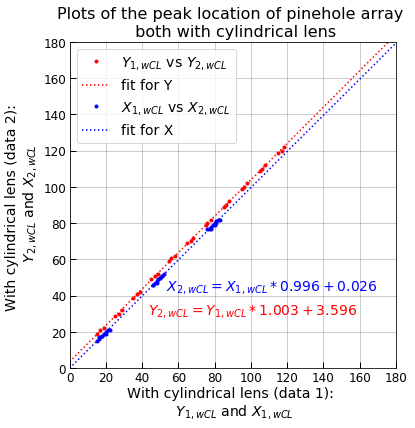

In [12]:
# plot the fit
plt.figure(figsize=(6, 6))
plt.plot(peaks_list[0][:,0], peaks_list[1][:,0], 'r.')
plt.plot([0, 180], [B3y, 180*A3y + B3y],'r:')
plt.plot(peaks_list[0][:,1], peaks_list[1][:,1], 'b.')
plt.plot([0, 180], [B3x, 180*A3x + B3x],'b:')

plt.legend([r'$Y_{1, wCL}$' +' vs '+r'$Y_{2, wCL}$', 
            'fit for Y', 
            r'$X_{1, wCL}$' +' vs '+r'$X_{2, wCL}$', 
            'fit for X'], fontsize=14,loc='upper left')
plt.xlabel('With cylindrical lens (data 1): \n '+r'$Y_{1, wCL}$' +' and ' + r'$X_{1, wCL}$' , fontsize = 14)
plt.ylabel('With cylindrical lens (data 2): \n '+r'$Y_{2, wCL}$' +' and ' + r'$X_{2, wCL}$' , fontsize = 14)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-0, 180)
plt.ylim(-0, 180)
plt.draw()
plt.title('Plots of the peak location of pinehole array \n both with cylindrical lens', fontsize = 16)

plt.grid('true')
plt.text(43, 30, s=r'$Y_{2, wCL} = Y_{1, wCL}*'+"{:.3f}".format(A3y)+'+'+"{:.3f}$".format(B3y),fontsize='14',color='r')
plt.text(53, 43, s=r'$X_{2, wCL} = X_{1, wCL}*'+"{:.3f}".format(A3x)+'+'+"{:.3f}$".format(B3x),fontsize='14',color='b')
ax = plt.gca()
ax.tick_params(direction='in', length=6, width=1, colors='black',
               grid_color='gray', grid_alpha=0.5,labelsize='12')

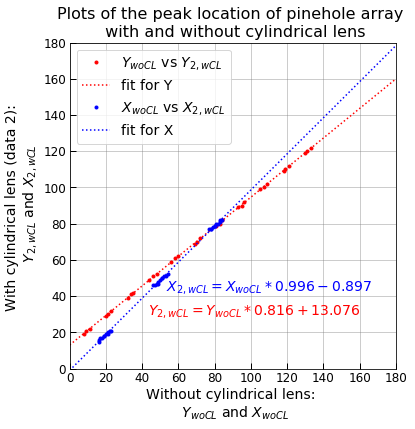

In [16]:
# plot the fit
ax=plt.figure(figsize=(6, 6))
plt.plot(peaks_list[2][:,0], peaks_list[1][:,0], 'r.')
plt.plot([0, 180], [B2y, 180*A2y + B2y],'r:')
plt.plot(peaks_list[2][:,1], peaks_list[1][:,1], 'b.')
plt.plot([0, 180], [B2x, 180*A2x + B2x],'b:')



plt.legend(['y coordiantes', 'x coordiantes', 'identical coordinates', 'fit for y'], fontsize=13,loc='upper left')
plt.xlabel('Without cylindrical lens', fontsize = 14)
plt.ylabel('With cylindrical lens (data 2)', fontsize = 14)


plt.legend([r'$Y_{woCL}$' +' vs '+r'$Y_{2, wCL}$', 
            'fit for Y', 
            r'$X_{woCL}$' +' vs '+r'$X_{2, wCL}$', 
            'fit for X'], fontsize=14,loc='upper left')
plt.xlabel('Without cylindrical lens: \n '
           +r'$Y_{woCL}$' 
           +' and ' 
           + r'$X_{woCL}$' , fontsize = 14)

plt.ylabel('With cylindrical lens (data 2): \n '+r'$Y_{2, wCL}$' +' and ' + r'$X_{2, wCL}$' , fontsize = 14)



plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-0, 180)
plt.ylim(-0, 180)
plt.draw()
plt.title('Plots of the peak location of pinehole array \n with and without cylindrical lens', fontsize = 16)

plt.grid('true')
plt.text(43,30,s=r'$Y_{2, wCL} = Y_{woCL}*'+"{:.3f}".format(A2y)+'+'+"{:.3f}$".format(B2y),fontsize='14',color='r')
plt.text(53, 43, s=r'$X_{2, wCL} = X_{woCL}*'+"{:.3f}".format(A2x)+"{:.3f}$".format(B2x),fontsize='14',color='b')
ax = plt.gca()
ax.tick_params(direction='in', length=6, width=1, colors='black',
               grid_color='gray', grid_alpha=0.5,labelsize='12')

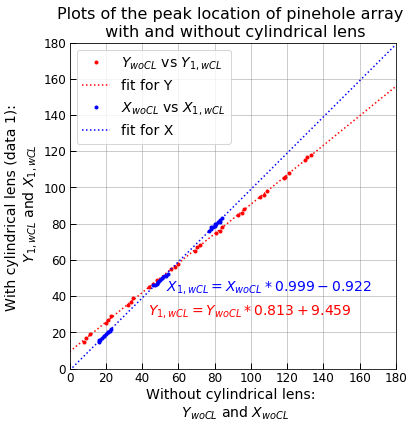

In [15]:
# plot the fit
ax=plt.figure(figsize=(6, 6))
plt.plot(peaks_list[2][:,0], peaks_list[0][:,0], 'r.')
plt.plot([0, 180], [B1y, 180*A1y + B1y],'r:')
plt.plot(peaks_list[2][:,1], peaks_list[0][:,1], 'b.')
plt.plot([0, 180], [B1x, 180*A1x + B1x],'b:')



plt.legend(['y coordiantes', 'x coordiantes', 'identical coordinates', 'fit for y'], fontsize=13,loc='upper left')
plt.xlabel('Without cylindrical lens', fontsize = 14)
plt.ylabel('With cylindrical lens (data 1)', fontsize = 14)


plt.legend([r'$Y_{woCL}$' +' vs '+r'$Y_{1, wCL}$', 
            'fit for Y', 
            r'$X_{woCL}$' +' vs '+r'$X_{1, wCL}$', 
            'fit for X'], fontsize=14,loc='upper left')
plt.xlabel('Without cylindrical lens: \n '
           +r'$Y_{woCL}$' 
           +' and ' 
           + r'$X_{woCL}$' , fontsize = 14)

plt.ylabel('With cylindrical lens (data 1): \n '+r'$Y_{1, wCL}$' +' and ' + r'$X_{1, wCL}$' , fontsize = 14)



plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-0, 180)
plt.ylim(-0, 180)
plt.draw()
plt.title('Plots of the peak location of pinehole array \n with and without cylindrical lens', fontsize = 16)

plt.grid('true')
plt.text(43,30,s=r'$Y_{1, wCL} = Y_{woCL}*'+"{:.3f}".format(A1y)+'+'+"{:.3f}$".format(B1y),fontsize='14',color='r')
plt.text(53, 43, s=r'$X_{1, wCL} = X_{woCL}*'+"{:.3f}".format(A1x)+"{:.3f}$".format(B1x),fontsize='14',color='b')
ax = plt.gca()
ax.tick_params(direction='in', length=6, width=1, colors='black',
               grid_color='gray', grid_alpha=0.5,labelsize='12')